In [1]:
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse 

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, datasets, models
# from efficientnet_pytorch import EfficientNet 
import copy
import tqdm
from PIL import Image
from torchsummary import summary
%matplotlib inline

In [7]:
data_dir = '/content/drive/My Drive/case_study/output_data/train'
val_dir = '/content/drive/My Drive/case_study/output_data/val'
list_labels = []
list_amount = []
for label in os.listdir(data_dir):
  list_labels.append(label)
  list_amount.append(len(os.listdir(os.path.join(data_dir, label))))
print(list_labels)
print(list_amount)
def load_split_train_test(datadir, valdir):
    train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])
    test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(valdir,
                    transform=test_transforms)
    num_train = len(train_data)
    num_val = len(test_data)
    # indices = list(range(num_train))
    # split = int(np.floor(valid_size * num_train))
    print(num_train)
    print(num_val)
    # np.random.shuffle(indices)
    # from torch.utils.data.sampler import SubsetRandomSampler
    # train_idx= indices
    # test_idx = indices[split:], indices[:split]
    # train_sampler = SubsetRandomSampler(train_idx)
    # test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                  batch_size=64, shuffle=True, num_workers=8)
    testloader = torch.utils.data.DataLoader(test_data,
                  batch_size=64, shuffle=True, num_workers=8)
    
    return trainloader, testloader
  
trainloader, testloader = load_split_train_test(data_dir, val_dir)
print(trainloader.dataset.classes)
classes = trainloader.dataset.classes
len(trainloader.dataset.classes)


['sheep', 'rupicapra']
[89, 90]
179
21
['rupicapra', 'sheep']


2

Text(0, 0.5, 'Num of images')

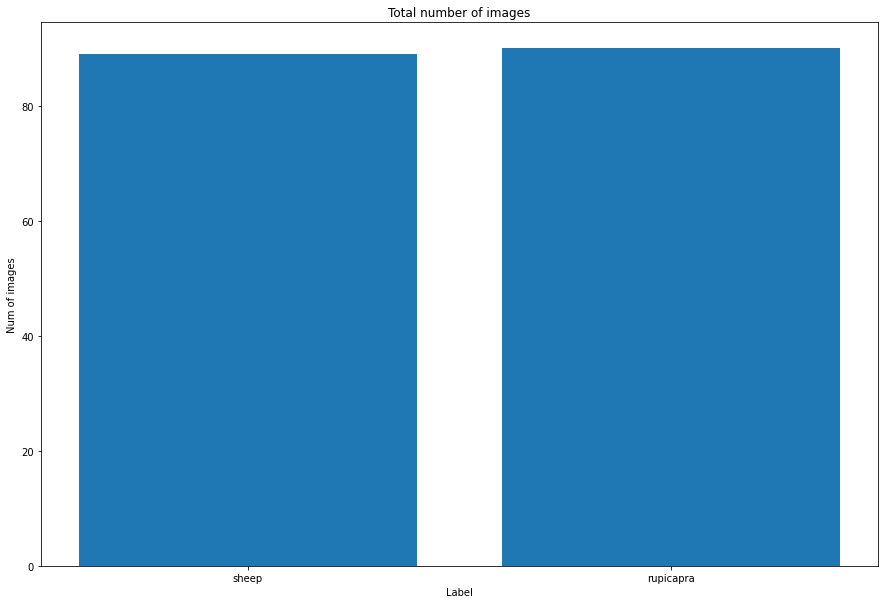

In [8]:
fig, ax = plt.subplots(figsize=(15,10)) 
labels = list_labels 
amount = list_amount 
# create bar chart 
ax.bar(labels, amount) 
# set title and labels 
ax.set_title('Total number of images') 
ax.set_xlabel('Label') 
ax.set_ylabel('Num of images')

In [9]:
device = torch.device("cuda")
model = models.resnet18(pretrained=True)
# model = EfficientNet.from_pretrained('efficientnet-b0')
print(model)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [17]:
for param in model.parameters():
    param.requires_grad = True
    
model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(128, 2),
                                 nn.LogSoftmax(dim=1))
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
model.to(device)
summary(model, input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [18]:
epochs = 30
steps = 0
running_loss = 0
print_every = 3
train_losses, test_losses, test_accuracies = [], [], []
for epoch in range(epochs):
#     if epoch == 50:
#       optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
#     if epoch == 100:
#       optimizer = optim.Adam(model.fc.parameters(), lr=0.0025)
#     if epoch == 150:
#       optimizer = optim.Adam(model.fc.parameters(), lr=0.002)
#     if epoch == 170:
#       optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
#     if epoch == 220:
#       optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
#     if epoch == 300:
#       optimizer = optim.Adam(model.fc.parameters(), lr=0.00001)
    stop = False
    for inputs, labels in trainloader:
      steps += 1
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      logps = model.forward(inputs)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
#       output = model(data)
      if steps % print_every == 0:
          test_loss = 0
          accuracy = 0
          model.eval()
          with torch.no_grad():
              for inputs, labels in testloader:
                  inputs, labels = inputs.to(device),labels.to(device)
                  logps = model.forward(inputs)
                  batch_loss = criterion(logps, labels)
                  test_loss += batch_loss.item()

                  ps = torch.exp(logps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          train_losses.append(running_loss/print_every)
          test_losses.append(test_loss/len(testloader))
          if(test_loss/len(testloader) < 0.02):
              stop = True
              break;
          test_accuracies.append(accuracy/len(testloader))                    
          print(f"Epoch {epoch+1}/{epochs}.. " 
                f"Train loss: {running_loss/print_every :.3f}.. "
                f"Test loss: {test_loss/len(testloader):.3f}.. "
                f"Test accuracy: {accuracy/len(testloader):.3f}")
          running_loss = 0
      model.train()
#       if epoch == 300:
#         torch.save(model, f'/content/drive/My Drive/Colab Notebooks/dermmodel112{epoch}.pth')
#       if epoch == 400:
#         torch.save(model, f'/content/drive/My Drive/Colab Notebooks/dermmodel112{epoch}.pth')       
#       if(stop):
#         break;
torch.save(model.state_dict(), '/content/drive/My Drive/case_study/dermmodel112.pth')


Epoch 1/30.. Train loss: 3.191.. Test loss: 2.181.. Test accuracy: 0.524
Epoch 2/30.. Train loss: 1.423.. Test loss: 0.755.. Test accuracy: 0.476
Epoch 3/30.. Train loss: 0.716.. Test loss: 0.675.. Test accuracy: 0.524
Epoch 4/30.. Train loss: 0.570.. Test loss: 0.693.. Test accuracy: 0.571
Epoch 5/30.. Train loss: 0.403.. Test loss: 0.598.. Test accuracy: 0.667
Epoch 6/30.. Train loss: 0.380.. Test loss: 1.089.. Test accuracy: 0.714
Epoch 7/30.. Train loss: 0.347.. Test loss: 0.593.. Test accuracy: 0.810
Epoch 8/30.. Train loss: 0.309.. Test loss: 0.594.. Test accuracy: 0.810
Epoch 9/30.. Train loss: 0.283.. Test loss: 0.516.. Test accuracy: 0.810
Epoch 10/30.. Train loss: 0.217.. Test loss: 0.428.. Test accuracy: 0.810
Epoch 11/30.. Train loss: 0.209.. Test loss: 0.581.. Test accuracy: 0.810
Epoch 12/30.. Train loss: 0.166.. Test loss: 0.750.. Test accuracy: 0.810
Epoch 13/30.. Train loss: 0.172.. Test loss: 0.570.. Test accuracy: 0.810
Epoch 14/30.. Train loss: 0.115.. Test loss: 0.

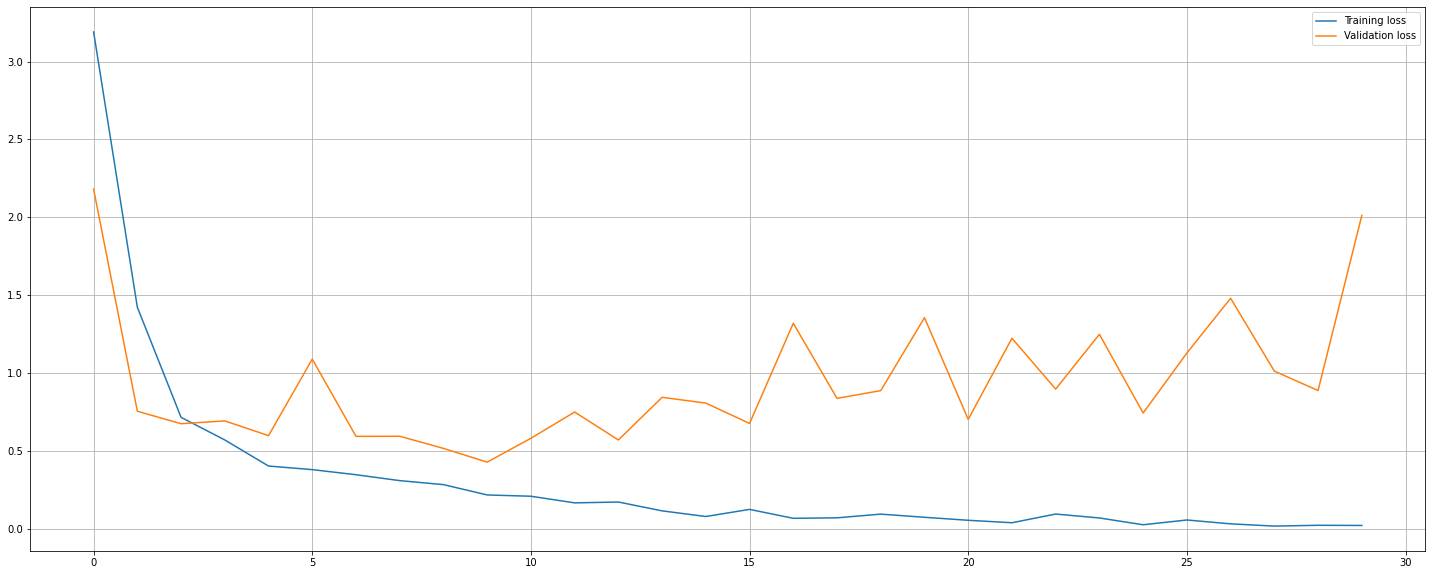

In [19]:
plt.figure(figsize=(25,10))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=True)
plt.grid(True)
plt.show()

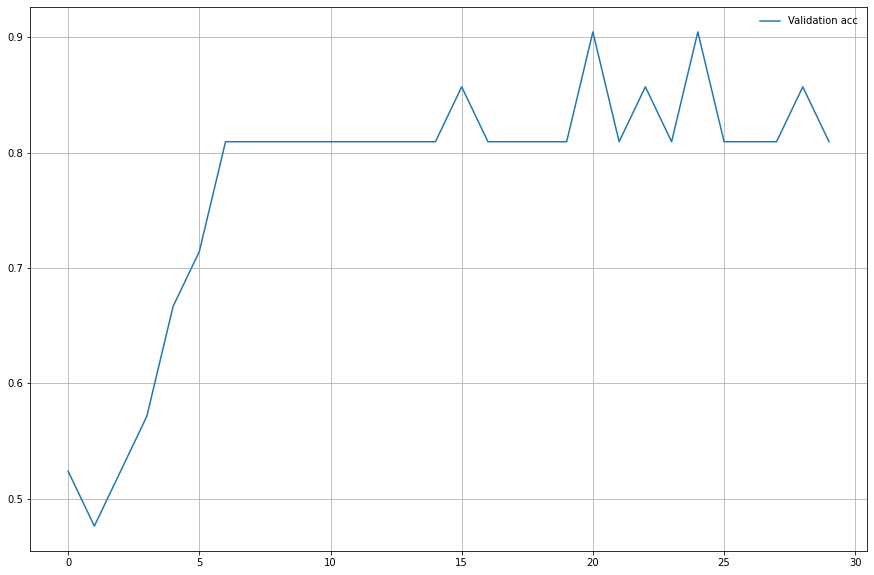

In [20]:
plt.figure(figsize=(15,10))
plt.plot(test_accuracies, label='Validation acc')
plt.legend(frameon=False)
plt.grid(True)
plt.show()

# New Section

In [ ]:
device = torch.device("cuda")
model=torch.load('/content/drive/My Drive/Colab Notebooks/dermmodel112.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torch.autograd import Variable
test_dir = '/content/drive/My Drive/Colab Notebooks/data/test'
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])
load_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(test_dir, transform=load_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

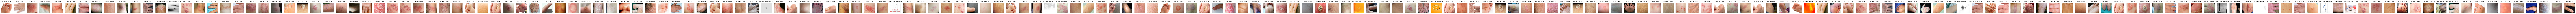

In [ ]:
to_pil = transforms.ToPILImage()
len_list_test = 200
true_count = 0
images, labels = get_random_images(len_list_test)
fig=plt.figure(figsize=(400,200))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    if int(labels[ii]) == index:
      true_count += 1
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
print(true_count)

165


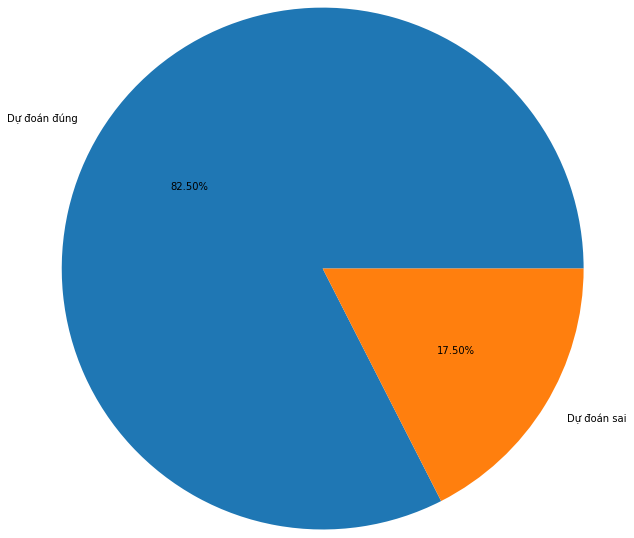

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
values = [true_count / 200, (200 - true_count) / 200] 
labels = ['Dự đoán đúng', 'Dự đoán sai'] 
plt.pie(values, labels=labels, autopct='%.2f%%', radius=3.0)
plt.show()